In [1]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2
import math
import pandas as pd
from CSL_2025_Python_codes import spim2XYZ, XYZ2Lab, spim2rgb, XYZ2RGB
from functions import *

1. Load Spectral Reflectances Cubes


In [ ]:
class sample_testing():
    def __init__(self, vis=True, test=False, trial=None, operator=None ):
        self.vis = vis
        self.test = test
        self.trial = trial
        self.operator = operator
        if self.test:
            self.base_folder = "../IDP Group A/test" + str(self.trial) + "/operator" + str(self.operator)
        else:
            self.base_folder = "../IDP Group A/train"
        sample_folders = [folder.name for folder in os.scandir(self.base_folder) 
                          if folder.is_dir() 
                          and folder.name not in ['dark', 'white', 'reference']]
        self.sample_folders = sorted(sample_folders, key=lambda x: int(x[1:]) if x.startswith("d") else float("inf"))
        self.wavelengths = list(range(450, 951, 20)) # Bands set in the lab when capturing images
        self.band = 530  # Band for image alignment
        
    def load_data(self):
        def load_cube(folder_path):
            tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
            tif_files.sort()

            cube = []
            for tif_file in tif_files:
                tif_path = os.path.join(folder_path, tif_file)
                tif = tiff.imread(tif_path)
                cube.append(tif)
            cube = np.array(cube)

            return cube

        # Load dark, white and reference cubes
        dark_cube = load_cube(os.path.join(self.base_folder, 'dark'))
        white_cube = load_cube(os.path.join(self.base_folder, 'white'))
        self.reference_cube = load_cube(os.path.join(self.base_folder, 'reference'))
        
        # Load samples
        denominator = white_cube - dark_cube
        denominator[denominator == 0] = 1e-6 # Avoid division by zero
        self.reference_cube =  (self.reference_cube - dark_cube) / denominator
        self.sample_cubes = {}
        for folder in self.sample_folders:
            sample_cube = load_cube(os.path.join(self.base_folder, folder))
            self.sample_cubes[folder] = (sample_cube - dark_cube) / denominator  # Shape: (bands, height, width)

    def process_reference(self, vis=False):
        print('Reference circle detection...')
        R_sample = self.reference_cube
        R_sample_interp, new_wavelengths = interpolate_spectral_cube(
            R_sample, self.wavelengths, wl_min=360, wl_max=830, wl_step=10)
        R_sample_interp = np.transpose(R_sample_interp, (1, 2, 0))  # (H, W, bands)

        ref_XYZ = spim2XYZ(R_sample_interp, new_wavelengths, "D65")
        self.ref_LAB = XYZ2Lab(ref_XYZ, new_wavelengths, "D65")
        self.ref_rgb = XYZ2RGB(ref_XYZ)

        ref_initial_center = detect_circle_center(self.ref_rgb, vis)
        ref_initial_mask = compute_IC_mask(self.ref_rgb, vis=vis, pixel_IC=ref_initial_center)
        ref_single_band = R_sample[self.wavelengths.index(self.band), :, :]
        self.ref_binary = gray_to_binary_image(ref_single_band)
        ref_circle_info = get_circle_info(ref_initial_mask, self.ref_rgb, vis)
        self.ref_center = (
            int(np.round(ref_circle_info["centroid"][0])),
            int(np.round(ref_circle_info["centroid"][1])),
        )
        #circle_center = ref_circle_info["min_enclosing_circle"]["center"]
        #self.ref_center = (int(np.round(circle_center[0])), int(np.round(circle_center[1])))
        self.ref_radius = int(np.round(ref_circle_info["min_enclosing_circle"]["radius"]))-5
        self.IC_visualization = [crop_circle(self.ref_rgb, self.ref_center, self.ref_radius)]

        ref_spectrum = average_reflectance_in_circle(R_sample, self.ref_center, self.ref_radius)
        self.spectra_visualization = {"reference": ref_spectrum}

        self.ref_mask = np.zeros(self.ref_LAB.shape[:2], dtype=np.uint8)
        cv2.circle(self.ref_mask, self.ref_center, self.ref_radius, 1, -1)

        self.ref_mask = ref_initial_mask
        
    def process_samples(self):
        self.samples_rgb = {}
        for sample in self.sample_folders:
            sample_cube = self.sample_cubes[sample]
            cube_interp, new_wavelengths = interpolate_spectral_cube(
                sample_cube, self.wavelengths, wl_min=360, wl_max=830, wl_step=10)
            cube_interp = np.transpose(cube_interp, (1, 2, 0))  # (H, W, b)
            sample_XYZ = spim2XYZ(cube_interp, new_wavelengths, "D65")
            self.samples_rgb[sample] = XYZ2RGB(sample_XYZ)

    def align_samples_to_reference(self, vis=True):
        self.homographies = {}
        for sample in self.sample_folders:
            print(f"Aligning {sample}...")
            sample_cube = self.sample_cubes[sample]
            sample_single_band = sample_cube[self.wavelengths.index(self.band), :, :]
            sample_binary = gray_to_binary_image(sample_single_band)
            #sample_binary = gray_to_binary_image(
            #get_example_reflectance(self.sample_cubes, sample, self.band))
            H = align_and_visualise_homography(self.ref_binary, sample_binary, sample, visualise=vis)
            self.homographies[sample] = H
        
            if vis:
                aligned, blended = align_and_blend_RGB_homography(self.ref_rgb, self.samples_rgb[sample], H, sample)
                overlay_mask(self.samples_rgb[sample], self.ref_mask, sample, color=(1, 0, 0), alpha=0.5)
                overlay_mask(aligned, self.ref_mask, f"aligned_{sample}", color=(1, 0, 0), alpha=0.5)

    def compute_CTQs(self, vis):
        self.deltaE_results = [] # CTQ1
        self.samples_radius = [] # CTQ2

        for sample in self.sample_folders:
            print(f"Processing {sample}...")
            # CTQ2 (in RGB)

            # Align sample to reference
            sample_rgb = extract_RGB(self.sample_cubes[sample], self.wavelengths)
            # sample_rgb = self.samples_rgb[sample]
            # sample_rgb = spim2rgb(self.sample_cubes[sample], self.wavelengths)
            # rgb_contrast = cv2.convertScaleAbs(img, alpha=1.5, beta=0)# contrast factor, brightness shift

            h, w, _ = sample_rgb.shape
            A_3x3 = self.homographies[sample]
            A_2x3 = A_3x3[:2, :]
            aligned = cv2.warpAffine(sample_rgb, A_2x3, (w, h))

            # Compute defect mask of IC to find circle radius
            sample_initial_mask = compute_IC_mask(sample_rgb, A_2x3, vis, self.ref_center)
            defect_circle_info = get_circle_info(sample_initial_mask, aligned, vis)
            self.samples_radius.append(defect_circle_info["min_enclosing_circle"]["radius"])

            # Masked IC region for visualization
            aligned_vis = cv2.warpAffine(self.samples_rgb[sample], A_2x3, (w, h))
            self.IC_visualization.append(crop_circle(aligned_vis, self.ref_center, self.ref_radius))

            # CTQ1 (all spectra)
            cube = self.sample_cubes[sample]
            bands, h, w = cube.shape

            # Align full cube and convert to LAB
            cube_aligned = np.stack(
                [cv2.warpAffine(cube[j], A_3x3[:2, :], (w, h)) for j in range(bands)]
            )
            cube_interp, new_wavelengths = interpolate_spectral_cube(
                cube_aligned, self.wavelengths, wl_min=360, wl_max=830, wl_step=10
            )
            cube_interp = np.transpose(cube_interp, (1, 2, 0))  # (H, W, b)
            sample_XYZ = spim2XYZ(cube_interp, new_wavelengths, "D65")
            sample_LAB = XYZ2Lab(sample_XYZ, new_wavelengths, "D65")

            # Cielab delta E with reference
            DE_mean = calculate_delta_E(self.ref_LAB, sample_LAB, mask=self.ref_mask)
            self.deltaE_results.append(DE_mean)


    def save_results(self):
        # Save results to df
        result_df = pd.DataFrame()
        result_df["defect_id"] = self.sample_folders
        result_df["DE_mean"] = self.deltaE_results
        result_df["D_radius"] = abs(np.array(self.samples_radius) - self.ref_radius)
        result_df["CTQ1"] = np.array(self.deltaE_results) > 2.8
        result_df["CTQ2"] = result_df["D_radius"] > 1.2
        result_df["Defect?"] = result_df["CTQ1"] | result_df["CTQ2"]
        return result_df

    def test_sample(self):
        self.load_data()
        self.process_reference()
        self.process_samples()
        self.align_samples_to_reference(False)
        self.compute_CTQs(False)
        res = self.save_results()
        self.plot_IC_regions()
        return res
    
    def plot_deltaE(self):
        plt.figure(figsize=(10, 5))
        plt.bar(self.result_df["defect_id"], self.result_df["DE_mean"], color="skyblue")
        plt.ylabel("DE (CIE2000)")
        plt.title("Average Color Difference (DE) Between Reference and Defects")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    def plot_IC_regions(self):
        titles = ["reference"] + self.sample_folders
        plt.figure(figsize=(18, 12))
        cols = 5
        rows = math.ceil((len(self.sample_folders) + 1) / cols)
        for idx, (img, title) in enumerate(zip(self.IC_visualization, titles)):
            plt.subplot(rows, cols, idx + 1)
            if img.ndim == 2:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            plt.title(title, fontsize=14, fontweight="bold")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    def plot_average_spectras(self):
        # Plot average spectra of each defect
        for defect_name in self.sample_folders:
            cube = self.sample_cubes[defect_name]
            spec = average_reflectance_in_circle(
                cube, self.ref_center, self.ref_radius, transform=self.homographies[defect_name]
            )
            self.spectra_vis[defect_name] = spec
        plt.figure(figsize=(10, 6))
        for name, spectrum in self.spectra_vis.items():
            plt.plot(self.wavelengths, spectrum, label=name)

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Average Reflectance")
        plt.title("Average Spectral Reflectance (Circular Regions)")
        plt.legend()
        plt.show()

Reference circle detection...
Aligning d1...
Aligning d2...
Aligning d3...
Aligning d4...
Aligning d5...
Aligning d6...
Aligning d7...
Aligning d8...
Aligning d9...
Aligning d10...
Aligning d11...
Aligning d12...
Aligning d13...
Aligning d14...
Processing d1...
Processing d2...
Processing d3...
Processing d4...
Processing d5...
Processing d6...
Processing d7...
Processing d8...
Processing d9...
Processing d10...
Processing d11...
Processing d12...
Processing d13...
Processing d14...


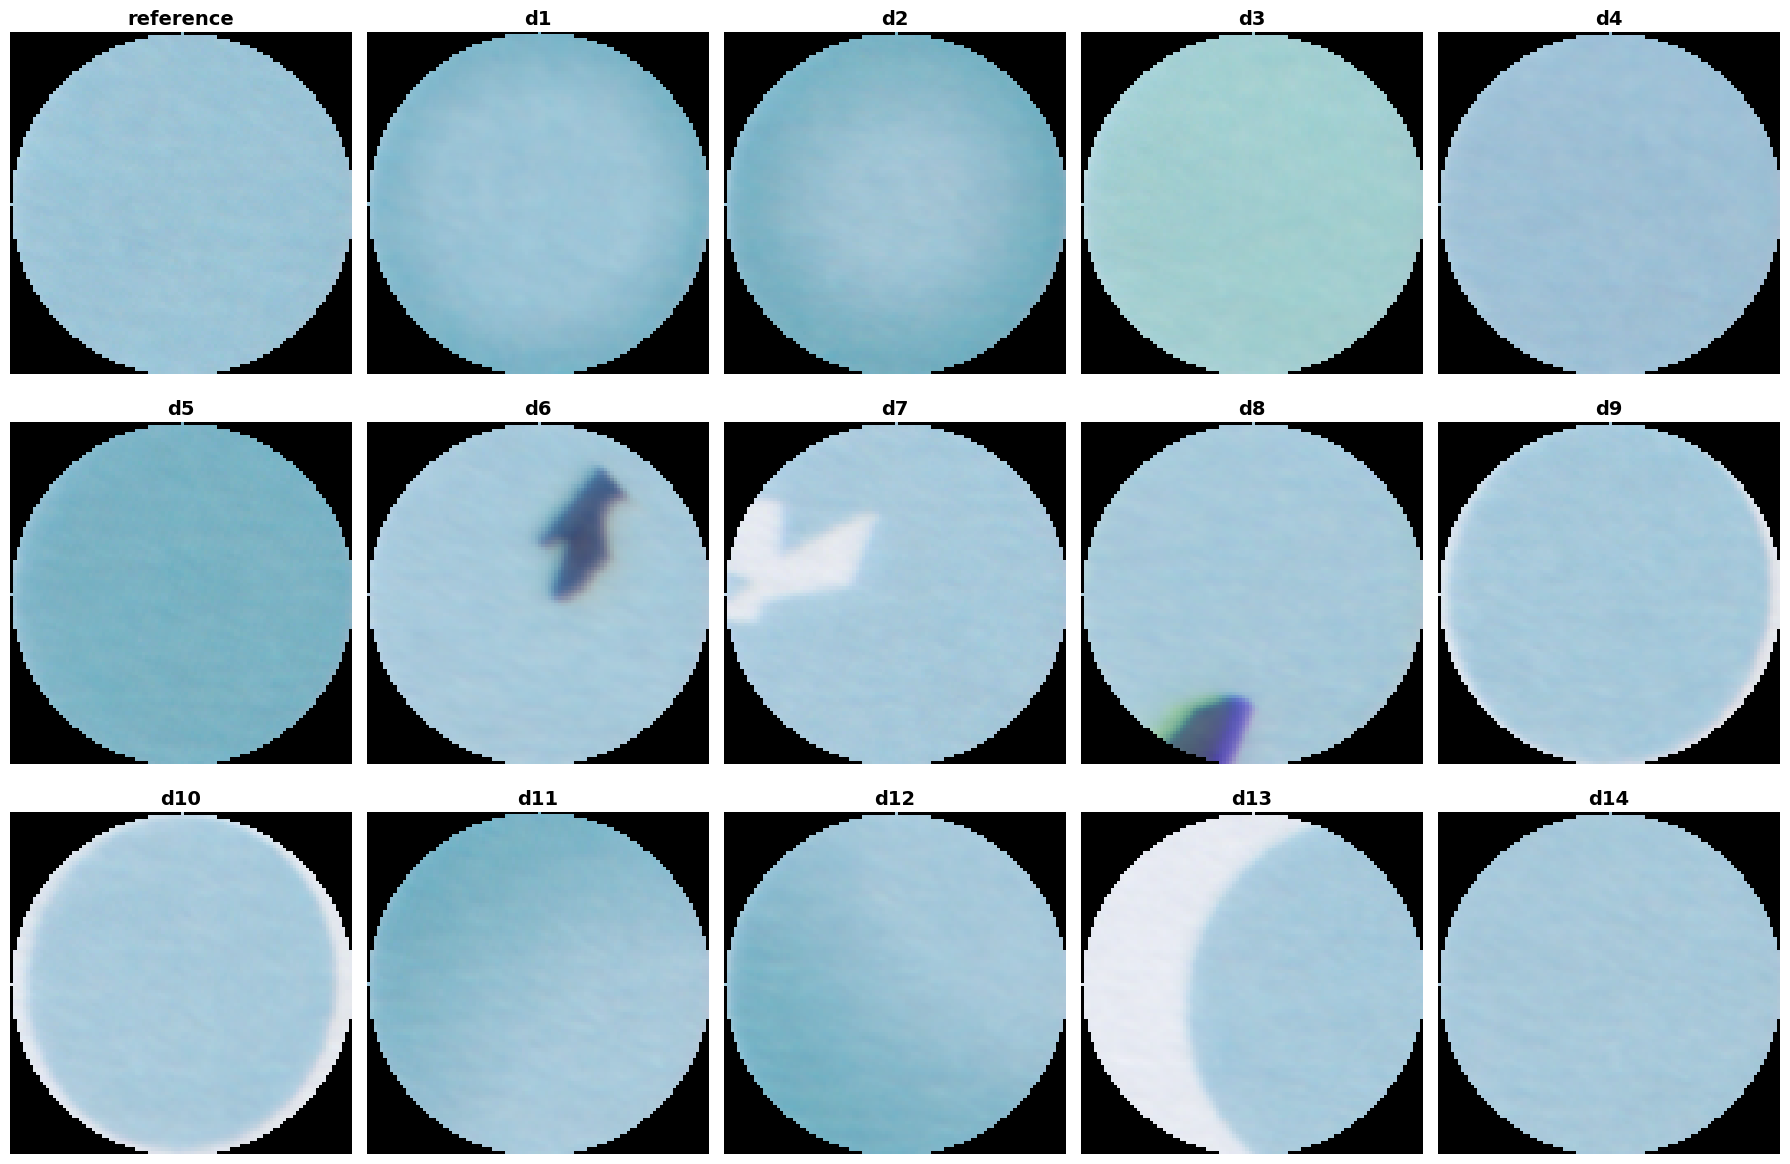

In [50]:
# Train samples
train = sample_testing(test=False, trial=2, operator=3)
result1 = train.test_sample()

In [10]:
# Save results from training
result1.to_csv("results_train.csv", index=False)

In [3]:
test11 = sample_testing(test=True, trial=1, operator=1)
result2 = test11.test_sample()

test12 = sample_testing(test=True, trial=1, operator=2)
result3 = test12.test_sample()

test13 = sample_testing(test=True, trial=1, operator=3)
result4 = test13.test_sample()

test21 = sample_testing(test=True, trial=2, operator=1)
result5 = test21.test_sample()

test22 = sample_testing(test=True, trial=2, operator=2)
result6 = test22.test_sample()

test23 = sample_testing(test=True, trial=2, operator=3)
result7 = test23.test_sample()

Reference circle detection...
Aligning d3...
Aligning d4...
Aligning d7...
Aligning d10...
Aligning d12...
Aligning d13...
Aligning d18...
Aligning d19...
Aligning d20...
Aligning d21...
Aligning d22...
Processing d3...
Processing d4...
Processing d7...
Processing d10...
Processing d12...
Processing d13...
Processing d18...
Processing d19...
Processing d20...
Processing d21...
Processing d22...
Reference circle detection...
Aligning d3...
Aligning d4...
Aligning d7...
Aligning d10...
Aligning d12...
Aligning d13...
Aligning d18...
Aligning d19...
Aligning d20...
Aligning d21...
Aligning d22...
Processing d3...
Processing d4...
Processing d7...
Processing d10...
Processing d12...
Processing d13...
Processing d18...
Processing d19...
Processing d20...
Processing d21...
Processing d22...
Reference circle detection...
Aligning d3...
Aligning d4...
Aligning d7...
Aligning d10...
Aligning d12...
Aligning d13...
Aligning d18...
Aligning d19...
Aligning d20...
Aligning d21...
Aligning d22...
P

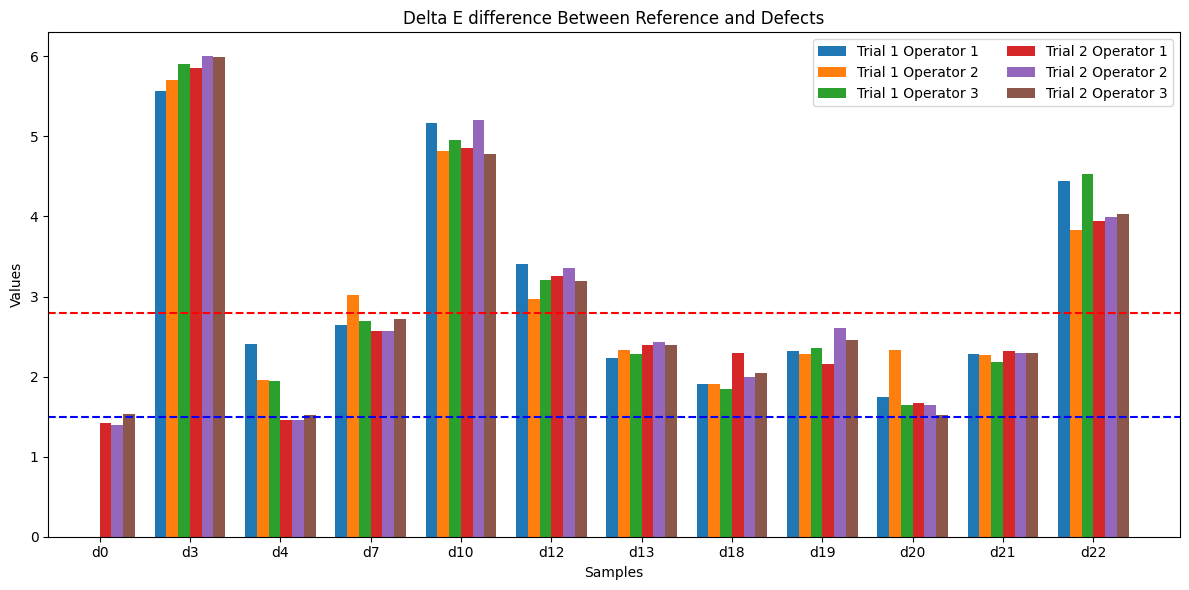

In [43]:
# Comparative plot of test CTQs
samples = test21.sample_folders
new_row = {
    "defect_id": "d0",
    "DE_mean": np.nan,
    "D_radius": np.nan,
    "CTQ1": np.nan,
    "CTQ2": np.nan,
    "Defect?": np.nan
}
#result2 = pd.concat([pd.DataFrame([new_row]), result2], ignore_index=True)
#result3 = pd.concat([pd.DataFrame([new_row]), result3], ignore_index=True)
#result4 = pd.concat([pd.DataFrame([new_row]), result4], ignore_index=True)

tests = [result2, result3, result4, result5, result6, result7]
all_deltae  = [t['DE_mean'].values  for t in tests]
all_radius  = [t['D_radius'].values for t in tests]
    
#all_deltae = np.array(all_deltae)
#all_radius = np.array(all_radius)
variances1 = np.nanvar(all_deltae, axis=0)
variances2 = np.nanvar(all_radius, axis=0)
def plot_ctq_values(values, title, threshold):
    x = np.arange(len(values[0]))
    width = 0.13

    plt.figure(figsize=(12, 6))
    plt.bar(x - 2.5*width, values[0], width, label='Trial 1 Operator 1')
    plt.bar(x - 1.5*width, values[1], width, label='Trial 1 Operator 2')
    plt.bar(x - 0.5*width, values[2], width, label='Trial 1 Operator 3')
    plt.bar(x + 0.5*width, values[3], width, label='Trial 2 Operator 1')
    plt.bar(x + 1.5*width, values[4], width, label='Trial 2 Operator 2')
    plt.bar(x + 2.5*width, values[5], width, label='Trial 2 Operator 3')
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)
    plt.axhline(y=1.5, color='blue', linestyle='--', linewidth=1.5)
    plt.xticks(x, samples)
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

plot_ctq_values(all_deltae,'Delta E difference Between Reference and Defects',2.8)
#plot_ctq_values(all_radius,'Radius difference Between Reference and Defects',1.2)
    

In [52]:
variances2

array([0.00508932, 0.10260792, 0.01637121, 0.00962264, 0.03429781,
       0.00671189, 0.13691517, 0.05199513, 0.0337822 , 0.01552465,
       0.05008835, 0.29804351])

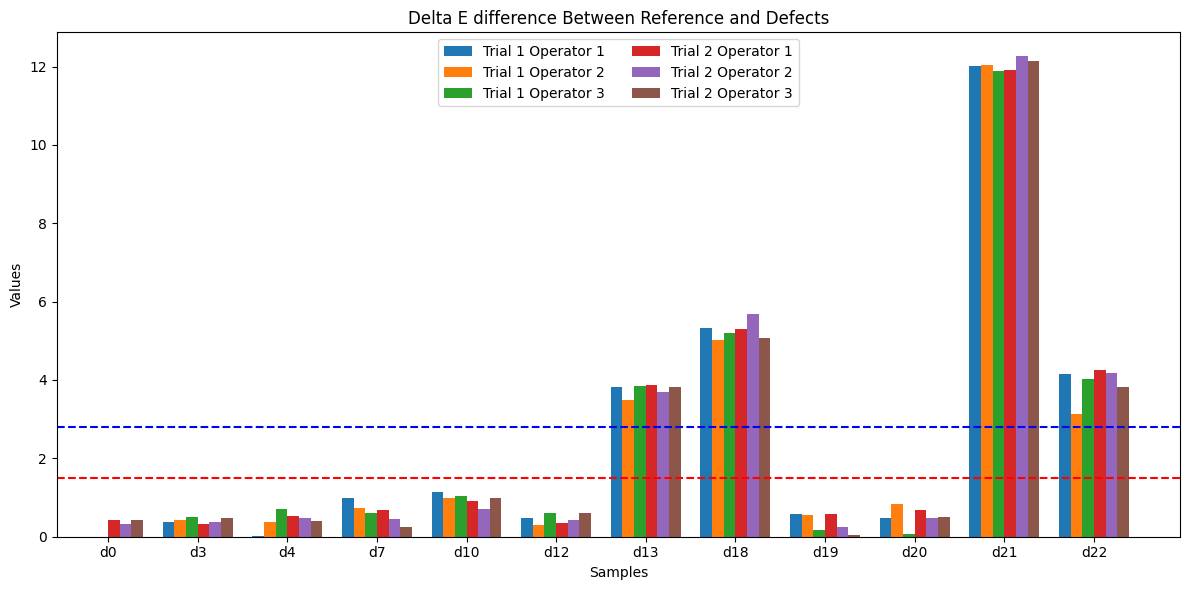

In [42]:
values1 = [np.nan, 0.37, 0.02, 1.00, 1.14, 0.47, 3.81, 5.33, 0.57, 0.48, 12.02, 4.15]
values2 = [np.nan,0.43, 0.38, 0.73, 0.98, 0.29, 3.49, 5.01, 0.55, 0.84, 12.05, 3.14]
values3 = [np.nan,0.50, 0.70, 0.60, 1.04, 0.61, 3.84, 5.19, 0.18, 0.06, 11.89, 4.02]
values4 = [0.43, 0.32, 0.52, 0.68, 0.91, 0.35, 3.87, 5.29, 0.59, 0.69, 11.90, 4.26]
values5 = [0.33, 0.38, 0.49, 0.45, 0.71, 0.42, 3.69, 5.69, 0.24, 0.49, 12.26, 4.19]
values6 = [0.42, 0.47, 0.39, 0.24, 1.00, 0.60, 3.83, 5.07, 0.05, 0.50, 12.13, 3.83]

# Define sample names (including d0)
sample_folders = ['d0', 'd3', 'd4', 'd7', 'd10', 'd12', 'd13', 'd18', 'd19', 'd20', 'd21', 'd22']

# Stack data for plotting
all_values = np.array([result2['D_radius'], values2, values3, values4, values5, values6])

# Plot setup
x = np.arange(len(sample_folders))
width = 0.13

plt.figure(figsize=(12, 6))
plt.bar(x - 2.5*width, values1, width, label='Trial 1 Operator 1')
plt.bar(x - 1.5*width, values2, width, label='Trial 1 Operator 2')
plt.bar(x - 0.5*width, values3, width, label='Trial 1 Operator 3')
plt.bar(x + 0.5*width, values4, width, label='Trial 2 Operator 1')
plt.bar(x + 1.5*width, values5, width, label='Trial 2 Operator 2')
plt.bar(x + 2.5*width, values6, width, label='Trial 2 Operator 3')
plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=2.8, color='blue', linestyle='--', linewidth=1.5)

plt.xticks(x, sample_folders)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Delta E difference Between Reference and Defects')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# Results from meeting 6

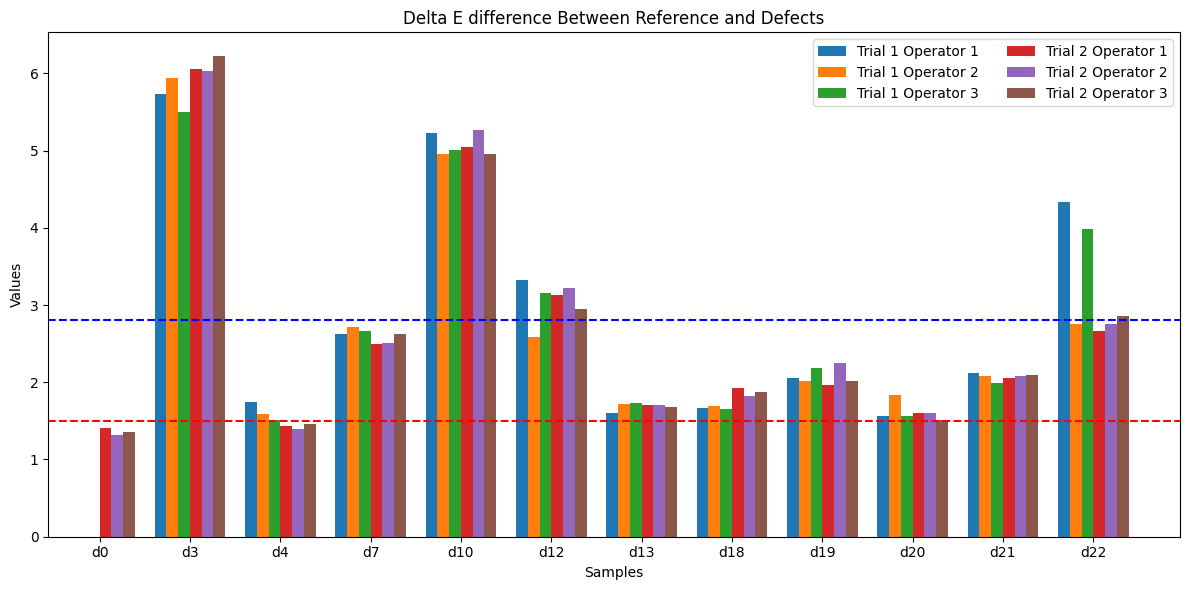

In [ ]:
# Values from presentatioon of meeting 6       
# Define all 6 lists
values1 = [np.nan, 5.73, 1.75, 2.62, 5.23, 3.32, 1.60, 1.67, 2.06, 1.56, 2.12, 4.33]
values2 = [np.nan, 5.94, 1.59, 2.71, 4.96, 2.59, 1.72, 1.69, 2.01, 1.84, 2.08, 2.76]
values3 = [np.nan, 5.50, 1.51, 2.66, 5.01, 3.16, 1.73, 1.65, 2.18, 1.56, 1.99, 3.98]

values4 = [1.41, 6.06, 1.44, 2.50, 5.04, 3.13, 1.70, 1.92, 1.96, 1.60, 2.06, 2.66]
values5 = [1.32, 6.03, 1.39, 2.51, 5.27, 3.22, 1.70, 1.82, 2.25, 1.60, 2.08, 2.76]
values6 = [1.36, 6.22, 1.46, 2.63, 4.95, 2.95, 1.68, 1.88, 2.01, 1.51, 2.10, 2.86]

# values1 = [np.nan, 0.37, 0.02, 1.00, 1.14, 0.47, 3.81, 5.33, 0.57, 0.48, 12.02, 4.15]
# values2 = [np.nan,0.43, 0.38, 0.73, 0.98, 0.29, 3.49, 5.01, 0.55, 0.84, 12.05, 3.14]
# values3 = [np.nan,0.50, 0.70, 0.60, 1.04, 0.61, 3.84, 5.19, 0.18, 0.06, 11.89, 4.02]
# values4 = [0.43, 0.32, 0.52, 0.68, 0.91, 0.35, 3.87, 5.29, 0.59, 0.69, 11.90, 4.26]
# values5 = [0.33, 0.38, 0.49, 0.45, 0.71, 0.42, 3.69, 5.69, 0.24, 0.49, 12.26, 4.19]
# values6 = [0.42, 0.47, 0.39, 0.24, 1.00, 0.60, 3.83, 5.07, 0.05, 0.50, 12.13, 3.83]

# Define sample names (including d0)
sample_folders = ['d0', 'd3', 'd4', 'd7', 'd10', 'd12', 'd13', 'd18', 'd19', 'd20', 'd21', 'd22']

# Stack data for plotting
all_values = np.array([result2['D_radius'], values2, values3, values4, values5, values6])

# Plot setup
x = np.arange(len(sample_folders))
width = 0.13

plt.figure(figsize=(12, 6))
plt.bar(x - 2.5*width, values1, width, label='Trial 1 Operator 1')
plt.bar(x - 1.5*width, values2, width, label='Trial 1 Operator 2')
plt.bar(x - 0.5*width, values3, width, label='Trial 1 Operator 3')
plt.bar(x + 0.5*width, values4, width, label='Trial 2 Operator 1')
plt.bar(x + 1.5*width, values5, width, label='Trial 2 Operator 2')
plt.bar(x + 2.5*width, values6, width, label='Trial 2 Operator 3')
plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=2.8, color='blue', linestyle='--', linewidth=1.5)

plt.xticks(x, sample_folders)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Delta E difference Between Reference and Defects')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

## STD

In [24]:
def std_reflectance_in_circle(hypercube, center, radius, transform=None):
    bands, h, w = hypercube.shape

    hypercube_aligned = np.stack(
        [cv2.warpAffine(hypercube[i], transform, (w, h)) for i in range(bands)]
    )

    mask = np.zeros((h, w), dtype=np.uint8)
    cx, cy = int(round(center[0])), int(round(center[1]))
    r = int(radius) - 5
    cv2.circle(mask, (cx, cy), r, 1, -1)

    std_reflectance = []
    for i in range(bands):
        band = hypercube_aligned[i]
        masked_pixels = band[mask == 1]
        if masked_pixels.size > 0:
            std_reflectance.append(np.std(masked_pixels))
        else:
            std_reflectance.append(np.nan)

    return np.array(std_reflectance)


new_spectra = {}
new_spectra_std = {}

for defect_name, transform in zip(defects, defect_homographies):
    cube = defect_cubes[defect_name]
    new_spectra[defect_name] = average_reflectance_in_circle(
        cube, circle_center, circle_radius, transform=transform
    )
    new_spectra_std[defect_name] = std_reflectance_in_circle(
        cube, circle_center, circle_radius, transform=transform
    )


for defect_name in defects:
    std_values = new_spectra_std[defect_name]
    mean_values = new_spectra[defect_name]

    print(
        f"{defect_name}: Mean Std across wavelengths = {np.nanmean(std_values):.6f}, Coefficient of Variation (mean) = {np.nanmean(std_values/mean_values)*100:.2f}%"
    )

d3: Mean Std across wavelengths = 0.020087, Coefficient of Variation (mean) = 3.57%
d4: Mean Std across wavelengths = 0.018204, Coefficient of Variation (mean) = 2.82%
d7: Mean Std across wavelengths = 0.017260, Coefficient of Variation (mean) = 2.52%
d10: Mean Std across wavelengths = 0.058129, Coefficient of Variation (mean) = 9.28%
d12: Mean Std across wavelengths = 0.083767, Coefficient of Variation (mean) = 13.76%
d13: Mean Std across wavelengths = 0.023273, Coefficient of Variation (mean) = 3.76%
d18: Mean Std across wavelengths = 0.018491, Coefficient of Variation (mean) = 2.91%
d19: Mean Std across wavelengths = 0.028793, Coefficient of Variation (mean) = 4.89%
d20: Mean Std across wavelengths = 0.018299, Coefficient of Variation (mean) = 2.81%
d21: Mean Std across wavelengths = 0.016123, Coefficient of Variation (mean) = 2.59%
d22: Mean Std across wavelengths = 0.049141, Coefficient of Variation (mean) = 8.13%


In [25]:
avg_std_per_defect = {
    name: np.nanmean(std_values) for name, std_values in new_spectra_std.items()
}

sorted_defects = sorted(avg_std_per_defect.items(), key=lambda x: x[1], reverse=True)
for rank, (name, std_val) in enumerate(sorted_defects, 1):
    print(f"{name}: {std_val:.6f}")

d12: 0.083767
d10: 0.058129
d22: 0.049141
d19: 0.028793
d13: 0.023273
d3: 0.020087
d18: 0.018491
d20: 0.018299
d4: 0.018204
d7: 0.017260
d21: 0.016123
